In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import numpy as np
import copy
from PIL import Image

## Модель

In [3]:
# model = torch.nn.Sequential(
#     torch.nn.Conv2d(1, 32, kernel_size = 3, padding = 1, padding_mode = 'replicate'),
#     torch.nn.MaxPool2d(kernel_size=2),
#     torch.nn.ReLU(),
#     torch.nn.Conv2d(32, 64, kernel_size = 3, padding = 1, padding_mode = 'replicate'),
#     torch.nn.MaxPool2d(kernel_size=2),
#     torch.nn.ReLU(),
#     torch.nn.Conv2d(64, 128, kernel_size = 3, padding = 1, padding_mode = 'replicate'),
#     torch.nn.MaxPool2d(kernel_size=2),
#     torch.nn.ReLU(),
#     torch.nn.Flatten(),
#     torch.nn.Dropout(0.2),
#     torch.nn.Linear(1152, 10)
#     )

In [4]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=1),

    nn.Conv2d(6, 32, kernel_size=3),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    
    nn.Conv2d(32, 64, kernel_size=3),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    
    nn.Conv2d(64, 128, kernel_size=5),
    nn.Tanh(),
    
    nn.Flatten(),
    
    nn.Linear(128, 64),
    #torch.nn.Dropout(p=0.5), 
    nn.Tanh(),
    
    nn.Linear(64, 10)
)

# model = model.to(device)
# from torchsummary import summary

# summary(model, input_size=(1, 28, 28))

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print(f"Model is on device: {next(model.parameters()).device}")

Model is on device: cuda:0


## 

In [7]:
transform = transforms.Compose([transforms.ToTensor()])
data_train = datasets.MNIST('./data', 
                            train = True,
                            download = True,
                            transform = transform
                           )
data_test = datasets.MNIST('./data',
                           train = False,
                           download = False, 
                           transform = transform
                          )

In [8]:
traindata = DataLoader(data_train, batch_size = 100, shuffle = True)
testdata = DataLoader(data_test, batch_size = 100, shuffle = True)

In [9]:
dataiter = iter(traindata)
data = next(dataiter)
features, labels = data

In [10]:
# Обучение
num_epochs = 50
loss = torch.nn.CrossEntropyLoss()
trainer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1, num_epochs + 1):
    losses_per_epoch = []
    for X, y in traindata:
        X, y = X.to(device), y.to(device)
        trainer.zero_grad()
        l = loss(model(X), y)
        losses_per_epoch.append(l.item())
        l.backward()
        trainer.step()
    if epoch % 5 == 0:
        print('epoch %d, loss: %f' % (epoch, np.mean(losses_per_epoch)))

epoch 5, loss: 0.043093
epoch 10, loss: 0.022330
epoch 15, loss: 0.016157
epoch 20, loss: 0.010238
epoch 25, loss: 0.009722
epoch 30, loss: 0.011372
epoch 35, loss: 0.008935
epoch 40, loss: 0.005393
epoch 45, loss: 0.007095
epoch 50, loss: 0.007828


In [11]:
# Тестирование модели
y_pred = []
y_true = []
for X, y in testdata:
    X, y = X.to(device), y.to(device)
    y_pred_iter = model(X)
    y_pred.extend(y_pred_iter.detach())
    y_true.extend(y.detach())

y_pred = torch.Tensor([torch.argmax(x) for x in y_pred])
y_true = torch.Tensor(y_true)

In [12]:
from sklearn.metrics import accuracy_score
print('Точность на тестовой выборке:', accuracy_score(y_true, y_pred))

Точность на тестовой выборке: 0.9888


In [13]:
# Замораживаем все слои
for param in model.parameters():
    param.requires_grad = False

## Сохранение модели

## Загрузка модели

# Предсказание

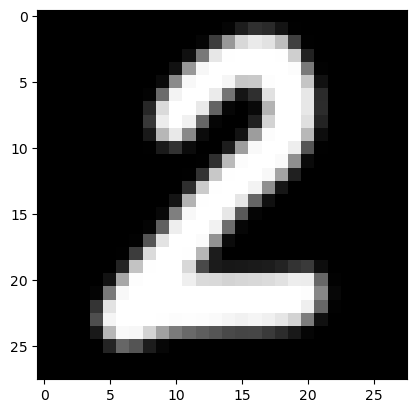

Предсказание. На избражении цифра 2
Выходы сети:
Цифра	Вес	Верояность
0	-2.11	0.0%
1	1.17	0.0%
2	21.56	100.0%
3	-2.84	0.0%
4	-1.87	0.0%
5	-10.02	0.0%
6	-0.83	0.0%
7	-4.46	0.0%
8	2.44	0.0%
9	-2.38	0.0%


In [55]:
# Загрузка изображения и преобразование в тензор
img = Image.open("digits/2_600i.jpg")
# Преобразование в Grayscale
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),  # Конвертация в 1 канал
    transforms.ToTensor()
])
tensor_img = transform(img)  # Теперь размер [1, 28, 28]
# one = torch.ones_like(tensor_img)
# tensor_img = torch.where(tensor_img > 0.5, one, tensor_img)

# Предсказание
x_pred = tensor_img.unsqueeze(dim=1).clone().to(device)

# one = torch.ones_like(x_pred)
# print(one)
# x_pred = torch.where(x_pred > 0.1, one, x_pred)
# print(x_pred)
y_pred = model(x_pred)
y = torch.argmax(y_pred).item()

# вывести картинку и результат
plt.imshow(torch.squeeze(tensor_img), cmap='gray')  # squeeze убирает размерность канала
# plt.title(img.filename + ';\nПредсказание: ' + str(y))
plt.show()

print(f"Предсказание. На избражении цифра {str(y)}")
# Применяем softmax для получения вероятностей
probabilities = F.softmax(y_pred, dim=1)
# Преобразуем в проценты и округляем
percentages = torch.squeeze((probabilities * 100).round())
print("Выходы сети:")
print("Цифра\tВес\tВерояность")
for i in range(10):   
    print(f"{i}\t{torch.squeeze(y_pred)[i].item():.2f}\t{percentages[i].item()}%")
